In [51]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('dark_background')

%matplotlib inline


import warnings 
warnings.filterwarnings('ignore')

In [52]:
data=pd.read_csv(r"C:\Users\sumee\Downloads\Algerian Forest Fires\Algerian_forest_fires_update_dataset.csv")

In [53]:
data.columns

Index(['day', 'month', 'year', 'Temperature', 'RH', 'Ws', 'Rain', 'FFMC',
       'DMC', 'DC', 'ISI', 'BUI', 'FWI', 'Classes', 'Region'],
      dtype='object')

## Drop day, month and year column

In [54]:
data.drop(['day', 'month', 'year'], axis = 1, inplace=True)

In [55]:
data.head()

,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,Region
0,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,not fire,0
1,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,not fire,0
2,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire,0
3,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0,not fire,0
4,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5,not fire,0


In [56]:
data['Classes'].value_counts()

Classes
fire             131
not fire         101
fire               4
fire               2
not fire           2
not fire           1
not fire           1
not fire           1
Name: count, dtype: int64

In [58]:
data['Classes'] = data['Classes'].str.strip()
data['Classes'].value_counts()

Classes
fire        137
not fire    106
Name: count, dtype: int64

<Axes: >

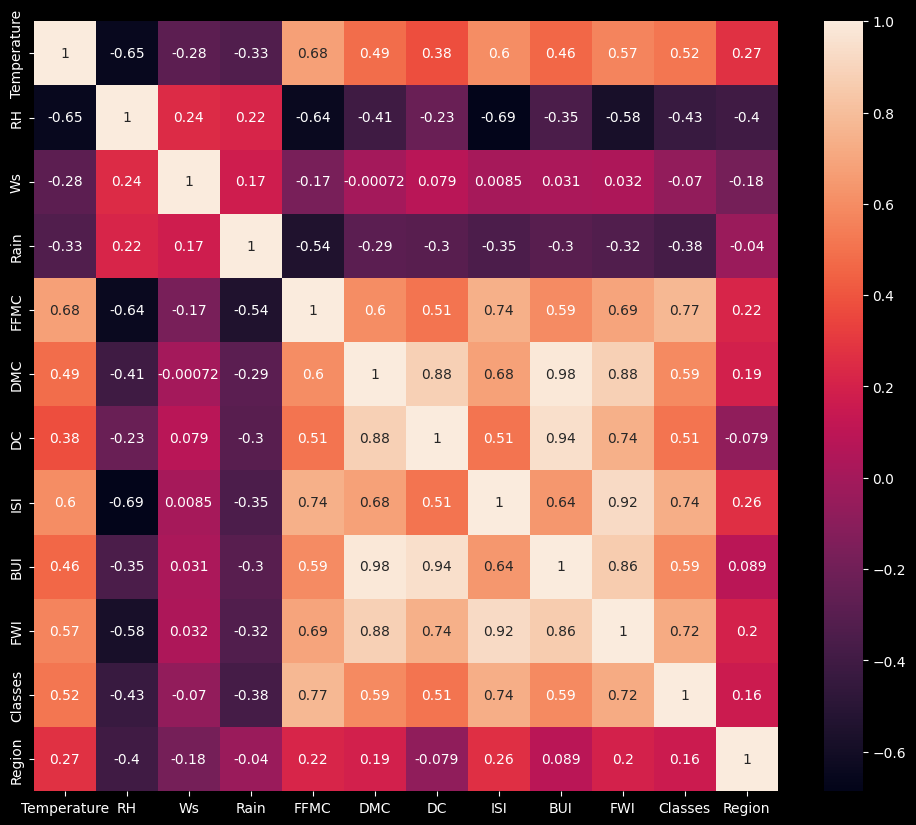

In [ ]:
plt.figure(figsize=(12,10))
corr = data.corr()
sns.heatmap(corr, annot=True)

In [ ]:
def correlation(dataset, threshold):
    col_corr =set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i,j]>threshold):
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

In [ ]:
corr_features = correlation(data, 0.85)

In [ ]:
corr_features

{'BUI', 'DC', 'FWI'}

In [ ]:
data = data.drop('DC', axis=1, inplace=True)

## Feature Engineering

In [65]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.model_selection import train_test_split

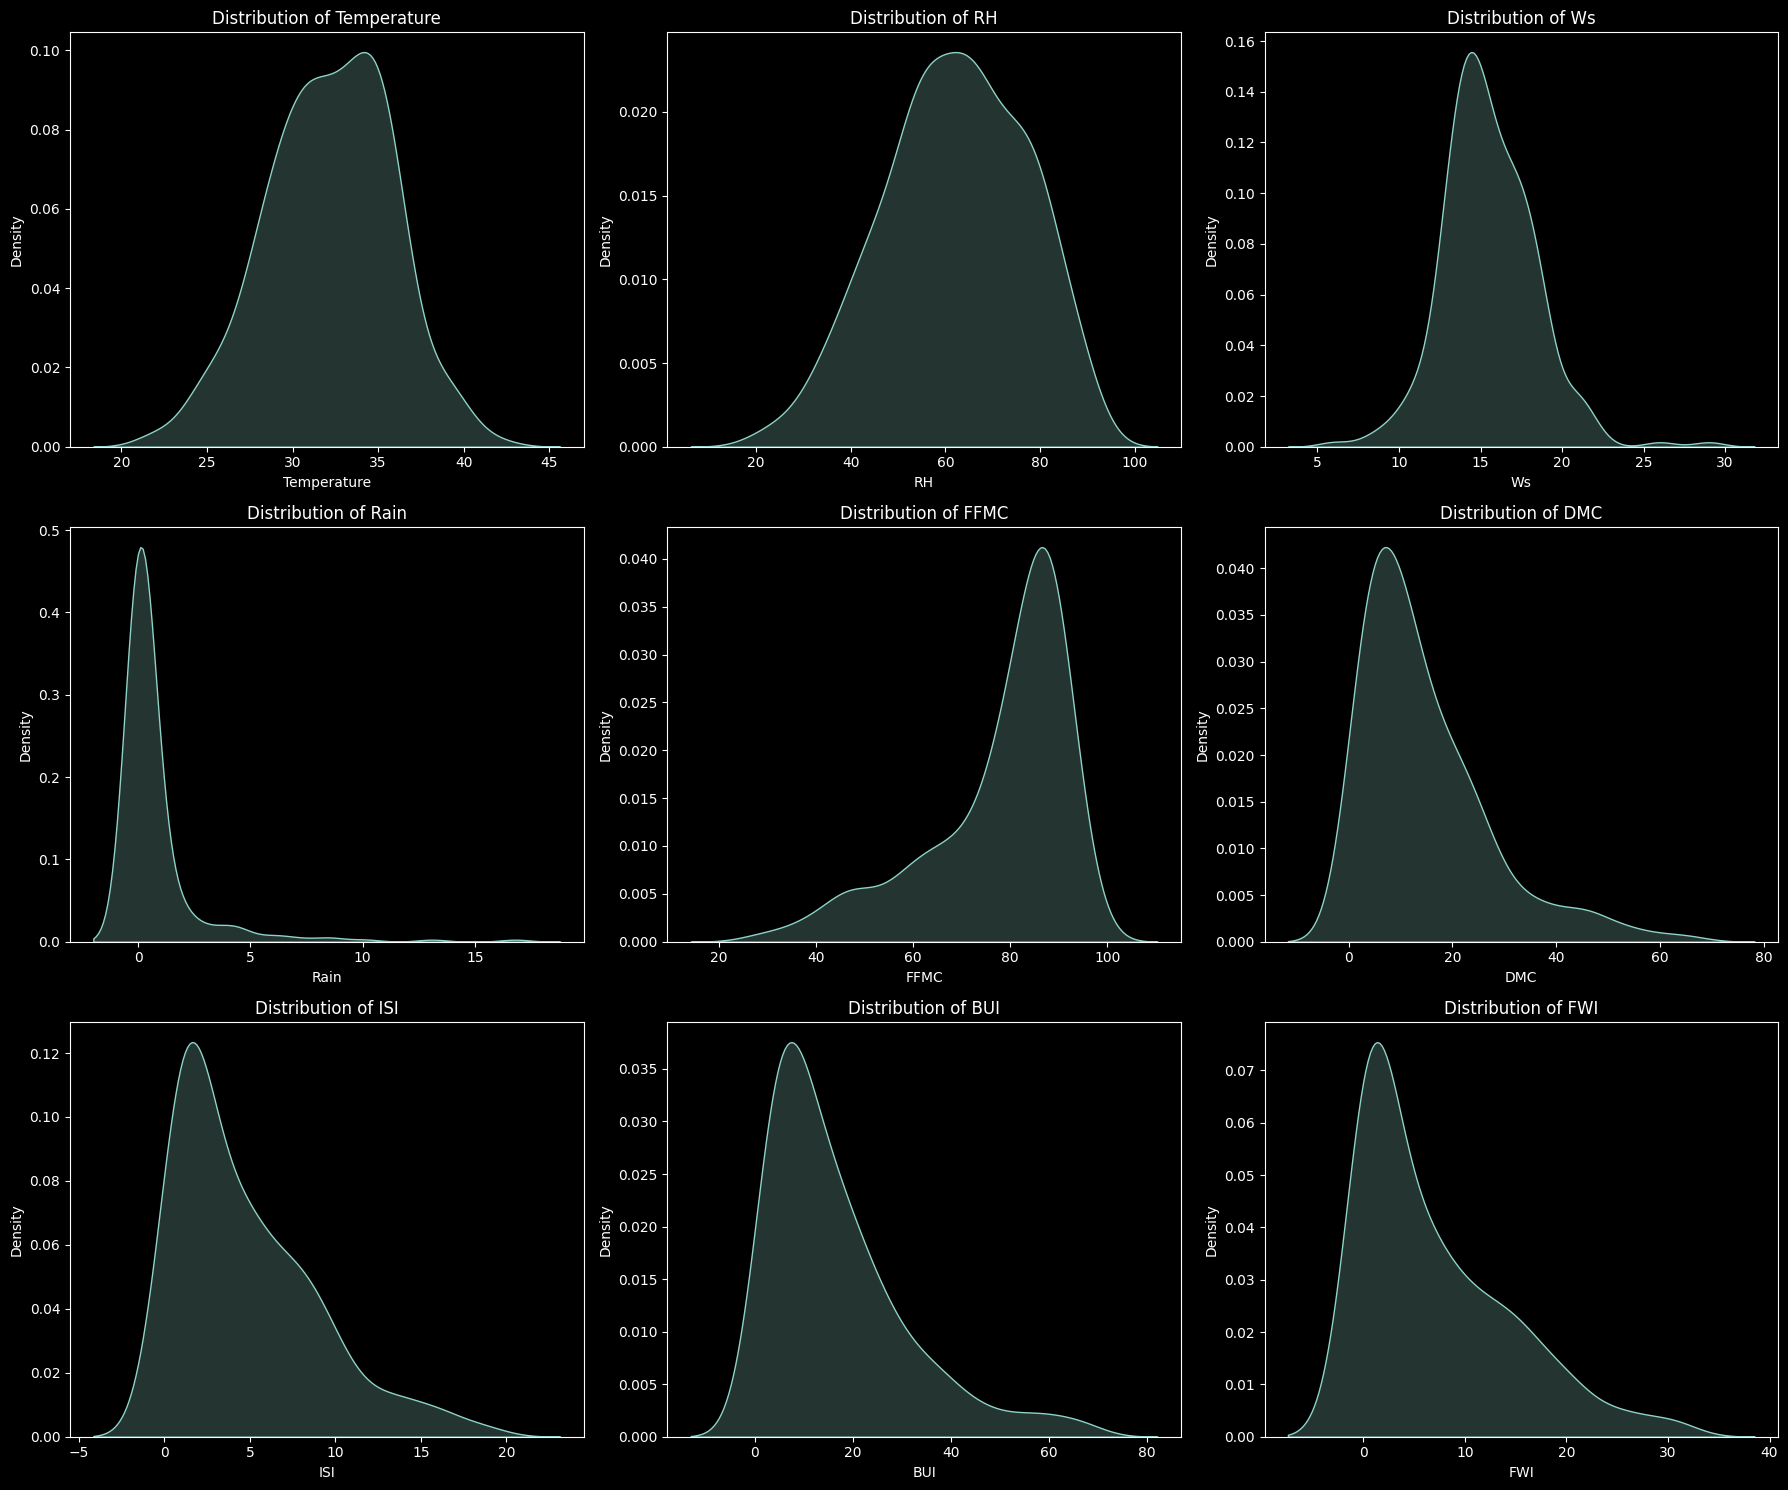

In [ ]:
columns_to_plot = [
    'Temperature', 'RH', 'Ws', 'Rain', 
    'FFMC', 'DMC', 'ISI', 'BUI', 'FWI'
]

df_to_plot = data[columns_to_plot]

n_cols = 3  
n_rows = (len(columns_to_plot) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, 
                         figsize=(6 * n_cols, 5 * n_rows))
axes = axes.flatten()

for i, col_name in enumerate(columns_to_plot):
    sns.kdeplot(data=df_to_plot, x=col_name, ax=axes[i], fill=True)
    axes[i].set_title(f'Distribution of {col_name}', fontsize=12)
    axes[i].set_xlabel(col_name, fontsize=10)
    axes[i].set_ylabel('Density', fontsize=10)

for j in range(len(columns_to_plot), n_rows * n_cols):
    fig.delaxes(axes[j])
plt.tight_layout()

In [59]:
data

,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,Region
0,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,not fire,0
1,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,not fire,0
2,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire,0
3,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0,not fire,0
4,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5,not fire,0
...,...,...,...,...,...,...,...,...,...,...,...,...
238,30,65,14,0.0,85.4,16.0,44.5,4.5,16.9,6.5,fire,1
239,28,87,15,4.4,41.1,6.5,8.0,0.1,6.2,0.0,not fire,1
240,27,87,29,0.5,45.9,3.5,7.9,0.4,3.4,0.2,not fire,1
241,24,54,18,0.1,79.7,4.3,15.2,1.7,5.1,0.7,not fire,1


In [60]:
X = data.drop(columns=['FWI'], axis=1)
y = data['FWI']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    train_size=0.2,
    random_state=42
)

In [ ]:
skewed_cols = ['Rain', 'FFMC', 'DMC', 'ISI', 'BUI']
unskewed_numeric_cols = ['Temperature', 'RH', 'Ws', 'Region']
categorical_cols = ['Classes']

skewed_numeric_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('transform', PowerTransformer(method='yeo-johnson'))
])

unskewed_numeric_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categoric_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoding', OrdinalEncoder(categories=[['not fire', 'fire']]))
])

tranformer = ColumnTransformer(
    transformers=[
        ('skewed', skewed_numeric_pipe, skewed_cols),
        ('unskewed', unskewed_numeric_pipe, unskewed_numeric_cols),
        ('catcol', categoric_pipe, categorical_cols)
    ],
    remainder='passthrough'
)

## Box PLot to understand the effect of standard scaling

Text(0.5, 1.0, 'After Scaling')

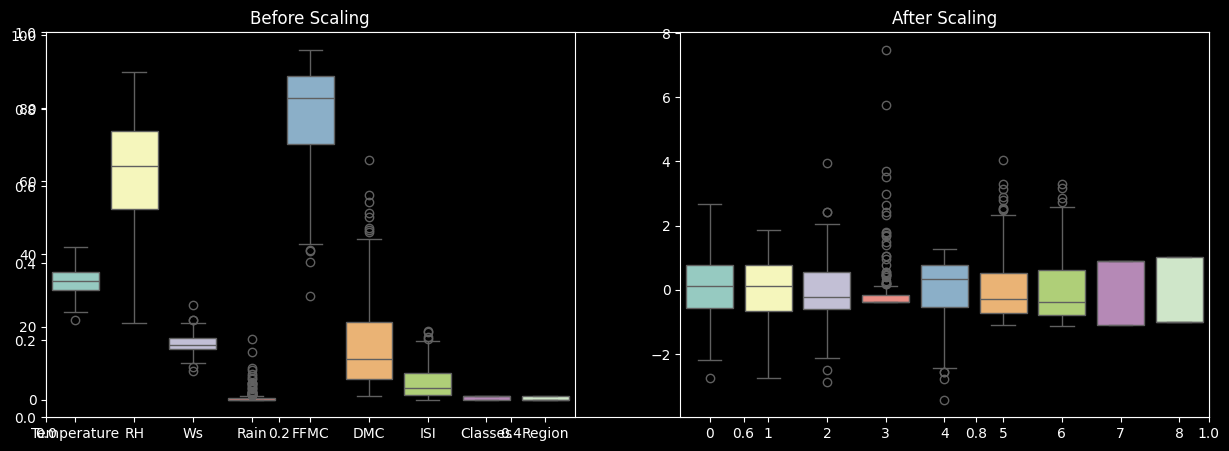

In [ ]:
plt.subplots(figsize=(15,5))
plt.subplot(1,2,1)
sns.boxplot(data=X_train)
plt.title("Before Scaling")
plt.subplot(1,2,2)
sns.boxplot(data=X_train_scaled)
plt.title("After Scaling")

## Linear Regression

Mean absolute error 0.5468236465249977
R2 score 0.9847657384266951


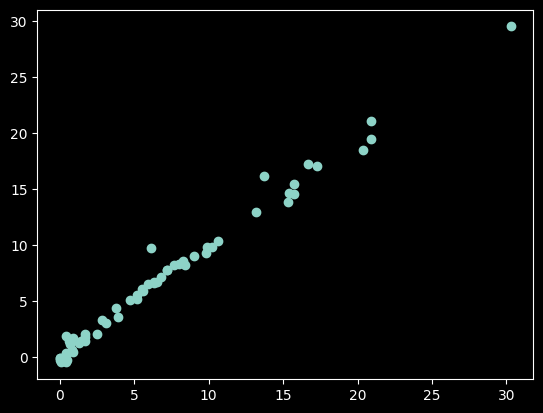

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

linear = LinearRegression()
linear.fit(X_train_scaled, y_train)
y_pred = linear.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
score = r2_score(y_test, y_pred)

print("Mean absolute error", mae)
print("R2 score", score)
plt.scatter(y_test, y_pred)

## Lasso

Mean absolute error 1.1331759949144085
R2 score 0.9492020263112388


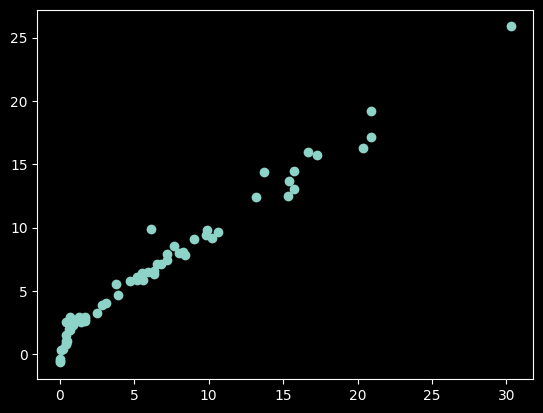

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

lasso = Lasso()
lasso.fit(X_train_scaled, y_train)
y_pred = lasso.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
score = r2_score(y_test, y_pred)

print("Mean absolute error", mae)
print("R2 score", score)
plt.scatter(y_test, y_pred)

## Cross Validation Lasso

In [ ]:
from sklearn.linear_model import LassoCV
la = LassoCV(cv=5)
la.fit(X_train_scaled, y_train)

LassoCV(cv=5)

Mean Absolute error 0.6199701158263433
R2 Score 0.9820946715928275


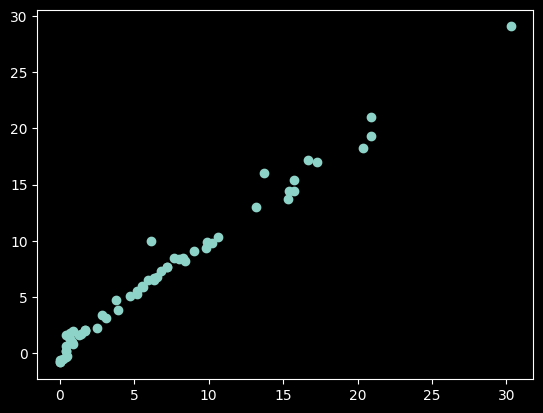

In [ ]:
y_pred = la.predict(X_test_scaled)
plt.scatter(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
score = r2_score(y_test, y_pred)
print("Mean Absolute error", mae)
print("R2 Score", score)

## Ridge Regression model

Mean Absolute error 0.5642305340105715
R2 Score 0.9834070933284211


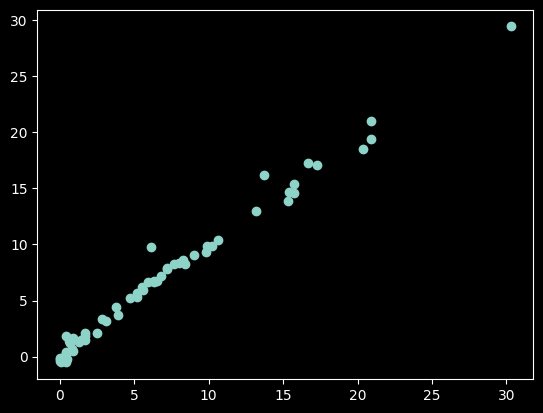

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

r = Ridge()
r.fit(X_train_scaled, y_train)
y_pred = r.predict(X_test_scaled)
mae = mean_absolute_error(y_pred, y_test)
score = r2_score(y_pred, y_test)
print("Mean Absolute error", mae)
print("R2 Score", score)
plt.scatter(y_test, y_pred)

In [ ]:
from sklearn.linear_model import RidgeCV
rc = RidgeCV(cv=5)
rc.fit(X_train_scaled, y_train)
y_pred = rc.predict(X_test_scaled)
print("Mean Absolute error", mae)
print("R2 Score", score)

Mean Absolute error 0.5642305340105715
R2 Score 0.9834070933284211


In [ ]:
rc.get_params()

{'alpha_per_target': False,
 'alphas': (0.1, 1.0, 10.0),
 'cv': 5,
 'fit_intercept': True,
 'gcv_mode': None,
 'scoring': None,
 'store_cv_results': None,
 'store_cv_values': 'deprecated'}

## Elasticnet Regression

Mean Absolute error 1.8822353634896
R2 Score 0.7814447243400926


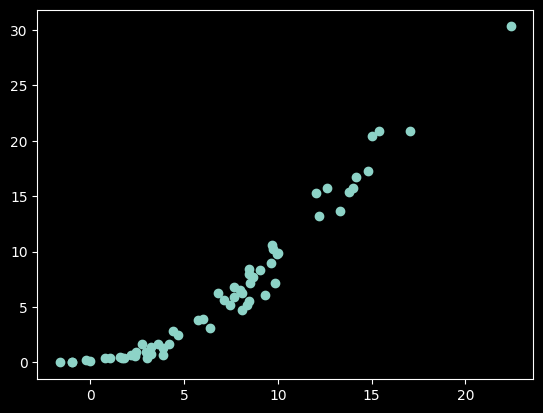

In [ ]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

el = ElasticNet()

el.fit(X_train_scaled, y_train)
y_pred = el.predict(X_test_scaled)

plt.scatter(y_pred, y_test)

mae = mean_absolute_error(y_pred, y_test)
score = r2_score(y_pred, y_test)
print("Mean Absolute error", mae)
print("R2 Score", score)

Mean Absolute error 0.6575946731430904
R2 Score 0.9799084998743879


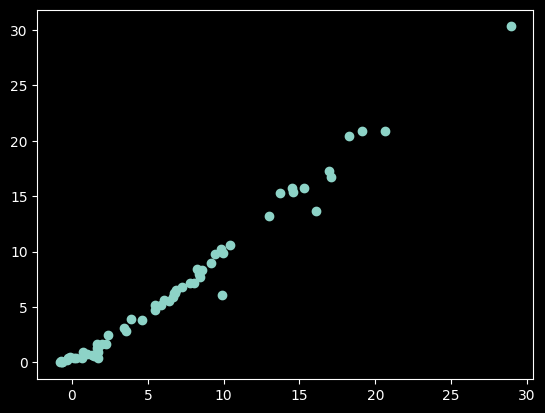

In [ ]:
from sklearn.linear_model import ElasticNetCV
e = ElasticNetCV(cv=5)

e.fit(X_train_scaled, y_train)
y_pred = e.predict(X_test_scaled)

plt.scatter(y_pred, y_test)

mae = mean_absolute_error(y_pred, y_test)
score = r2_score(y_pred, y_test)
print("Mean Absolute error", mae)
print("R2 Score", score)

## Pickle the machine learning models, preprocessing model standardscaler

In [ ]:
standard

StandardScaler()

In [ ]:
r

Ridge()

In [ ]:
import joblib

joblib.dump(standard, "scaler.pkl")
joblib.dump(r, "ridge.pkl")


['ridge.pkl']